In [71]:
import riversim

In [72]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def plot(fig, ax, model):

    ax.set_aspect('equal')

    #plt.rcParams['figure.figsize'] = [20, 20]
    
    ax.cla()
    
    for river_pr in model.rivers:
        x = ([v.x for v in river_pr.data().vertices])
        y = ([v.y for v in river_pr.data().vertices])
        ax.plot(x, y)

    xmin = 0
    xmax = 0
    ymin = 0
    ymax = 0
    for boundary_pr in model.region:
        x = ([v.x for v in boundary_pr.data().vertices])
        y = ([v.y for v in boundary_pr.data().vertices])
        x.append(boundary_pr.data().vertices[0].x)
        y.append(boundary_pr.data().vertices[0].y)
        if min(x) < xmin:
            xmin = min(x)
        if max(x) > xmax:
            xmax = max(x)
        if min(y) < ymin:
            ymin = min(y)
        if max(y) > ymax:
            ymax = max(y)
        ax.plot(x, y)

    ax.set_xlim(xmin - 0.1, xmax + 0.1)
    ax.set_ylim(ymin - 0.1, ymax + 0.1)
    #plt.xlim(xmin - 0.1, xmax + 0.1)
    #plt.ylim(ymin - 0.1, ymax + 0.1)
    #plt.show()
    display(fig)
    clear_output(wait = True)
    plt.pause(0.5)

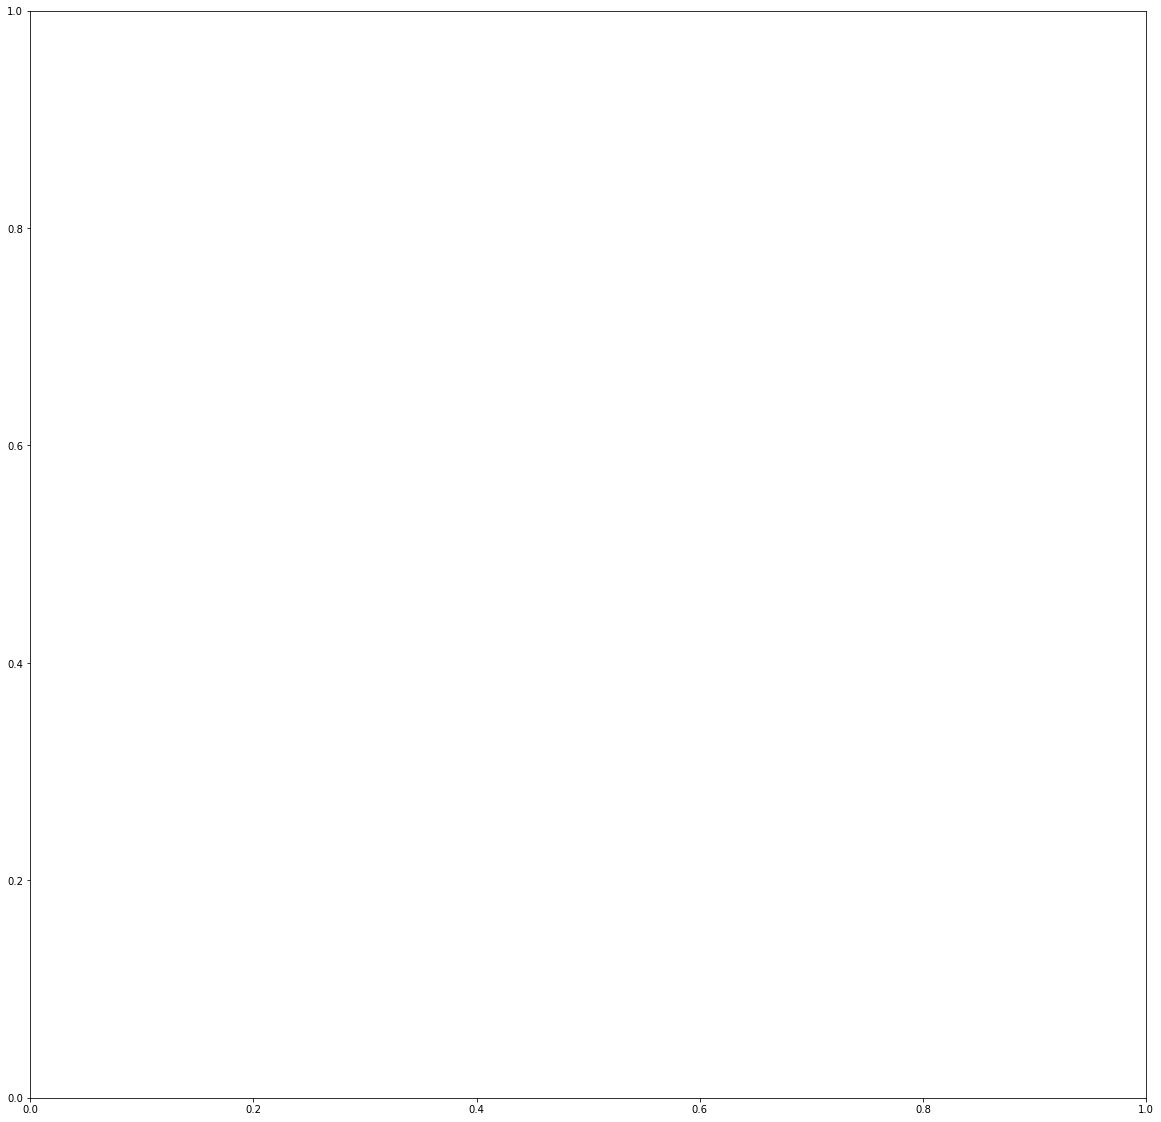

In [73]:
model = riversim.Model()
model.bifurcation_type = 1
model.bifurcation_threshold = -0.1
model.bifurcation_min_dist = 0.01
model.height = 4
model.width = 4
model.dx = 2

prog_opt = riversim.ProgramOptions()
solver = riversim.Solver(model.solver_params, prog_opt.verbose)
triangle = riversim.Triangle(model.mesh_params)
mesh = riversim.TethexMesh()

# initialziation of initial state
model.initializeLaplace()
sources = model.sources
rivers = model.rivers
region = model.region
boundary_conditions = model.boundary_conditions
boundary_conditions[3].value = 3
river_boundary_id = model.river_boundary_id

# grow each river for length of 0.1 to avoid circular integaration aroud tips in empty area(outside of region)
for source_id in sources.getSourcesIds():
    rivers[source_id].addPoint(riversim.Polar(0.1, 0), river_boundary_id)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#river_solver = riversim.RiverSolver(model, prog_opt)
#model = river_solver.model

#river_solver.model.boundary_conditions[3].value = 3
##river_solver.run()
#plot(river_solver.model)

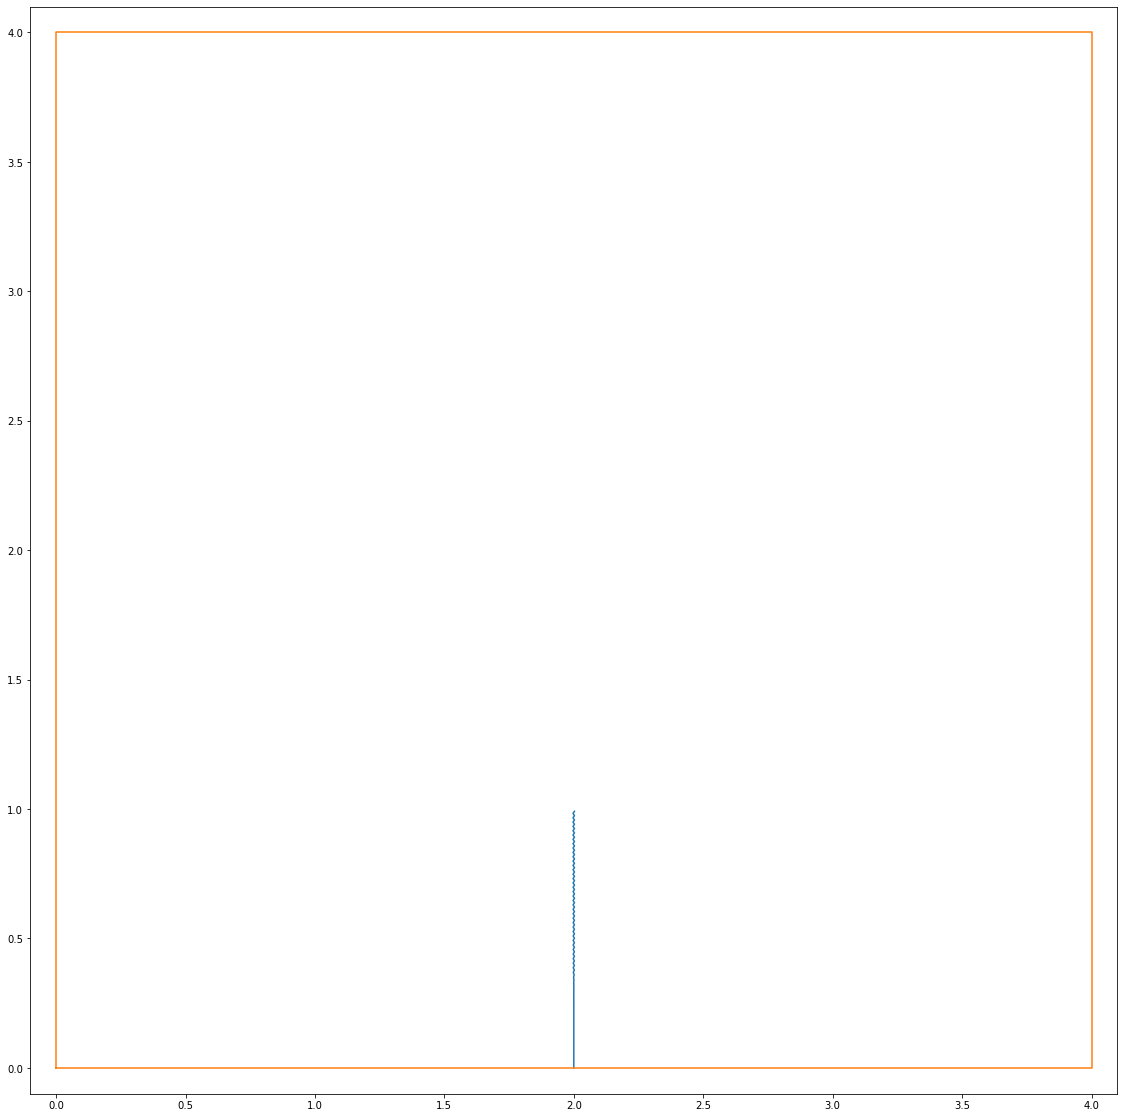

In [74]:
for i in range(100):
    # boundary generation: Combines boundary and river geometry into one(or several) closed boundary lines
    boundary = riversim.BoundaryGenerator(\
        sources, \
        region, \
        rivers, \
        model.river_width, \
        model.mesh_params.smoothness_degree, \
        model.mesh_params.ignored_smoothness_length)

    # mesh will be refined aroud tip points
    triangle.mesh_params.tip_points = rivers.tipPoints()
    mesh = triangle.generate(boundary, region.holes)

    # reset solver values
    # solver.clear() lets try without it
    solver.openMesh(mesh)

    model.solver_params.adaptive_refinment_steps = 1
    for j in range(model.solver_params.adaptive_refinment_steps):
        if j > 0:
            solver.refineGrid()
        solver.setupSystem()
        solver.assembleSystem(boundary_conditions)
        solver.solve()

    #series parameters evaluation
    id_series_params = riversim.t_ids_series_params()
    max_a1 = 0
    for id in rivers.tipBranchesIds():
        tip_point = rivers[id].tipPoint()
        tip_angle = rivers[id].tipAngle()
        id_series_params[id] = solver.integrate_new(model.integr_params, tip_point, tip_angle)
        if id_series_params[id][0] > max_a1:
            max_a1 = id_series_params[id][0]

    for id_series_param in id_series_params:
        id = id_series_param.key()
        series_param = id_series_param.data()
        if model.qGrowth(series_param):
            l = rivers[id].lenght()
            if model.qBifurcate(series_param, l):
                tip_point = rivers[id].tipPoint()
                tip_angle = rivers[id].tipAngle()
                br_left = riversim.Branch(tip_point, tip_angle + model.bifurcation_angle)
                br_left.addPoint(riversim.Polar(model.ds, 0), river_boundary_id)
                br_right = riversim.Branch(tip_point, tip_angle - model.bifurcation_angle)
                br_right.addPoint(riversim.Polar(model.ds, 0), river_boundary_id)
                rivers.addSubBranches(id, br_left, br_right)
            else: 
                rivers[id].addPoint(\
                    model.nextPoint(series_param, l, max_a1),\
                    river_boundary_id)

    plot(fig, ax, model)